# 1.   Прогнозирование заказов такси

### 1.1   Цель работы

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо проанализировать данные, представить их в удобном виде, выявить тренд и сезонность данных, обучить несколько моделей на разных алгоритмах с меняющимися гиперпараметрами и выбрать наилучшую модель для прогнозирования. Количество заказов находится в столбце 'num_orders'</div>

# 2.   Работа с данными

## 2.1.   Подготовка

In [1]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

In [2]:
data = pd.read_csv('/datasets/taxi.csv')

In [3]:
display(data.head())
display(data[data['num_orders'].isna()])

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


,datetime,num_orders


<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
На первый взгляд данные чистые</div>

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Превратим datetime в соответствующий тип данных</div>

In [5]:
data['datetime'] = pd.to_datetime(data['datetime'])

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Внесем данные времени в индексы</div>

In [7]:
data.set_index('datetime', inplace=True)

In [8]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Шаг в 10 минут. Ресемплирование будем выполнять по часу, с агрегацией среднего</div>

In [9]:
data = data.resample('1H').sum()

In [10]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Для комфортного анализа отсортируем индексы</div>

In [11]:
data.sort_index(inplace=True)

In [12]:
data.index.is_monotonic

True

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Отлично, время находится там, где нужно, шаг в один час, данные отсортированы</div>

In [13]:
print(f'min: {data.index.min()}')
print(f'max: {data.index.max()}')

min: 2018-03-01 00:00:00
max: 2018-08-31 23:00:00


<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Имеем данные за полгода – с начала марта 2018 до конца августа 2018</div>

## 2.2.   Анализ

### 2.2.1.   Технический анализ

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Посмотрим данные на графике</div>

<AxesSubplot:xlabel='datetime'>

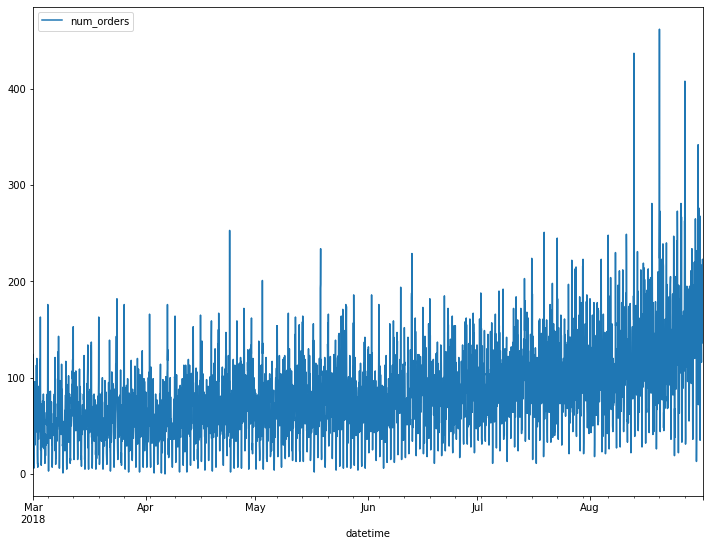

In [14]:
data.plot(figsize=(12, 9))

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Видно, что тренд (довольно слабый) присутствует, обеспечивая стационарность. На первый взгляд сезонность имеется, однако, стоит провести чуть более глубокий анализ</div>

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Посмотрим на скользящее среднее с окном в 1 и 5 дней</div>

In [15]:
data['1_roll'] = data['num_orders'].rolling(24).mean()
data['5_roll'] = data['num_orders'].rolling(24*5).mean()

<AxesSubplot:xlabel='datetime'>

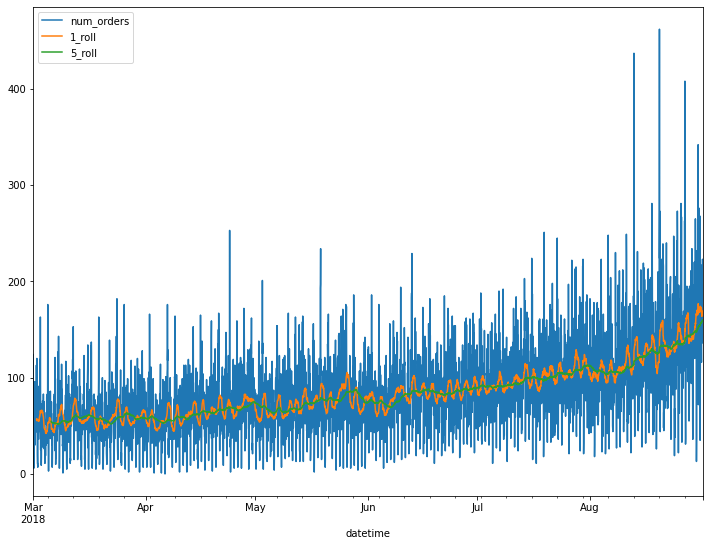

In [16]:
data.plot(figsize=(12, 9))

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Определенно, тренд заметен. Попробуем узнать сезонность с помощью seasonal_decompose</div>

<AxesSubplot:xlabel='datetime'>

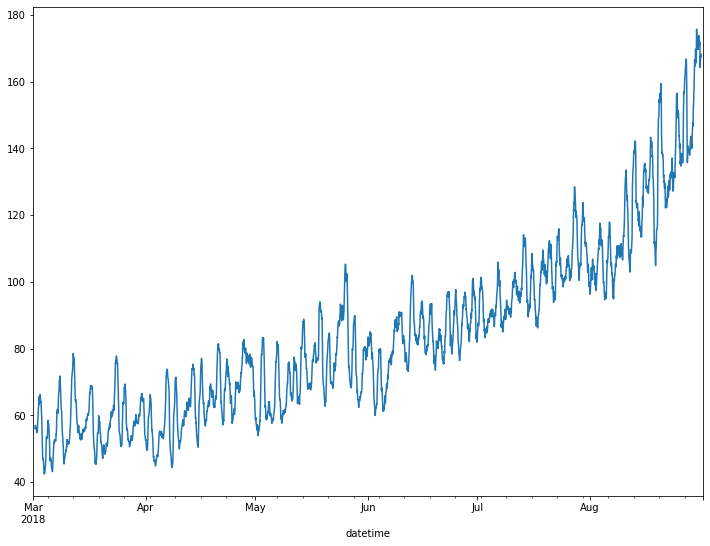

In [17]:
seasonal_decompose(data['num_orders']).trend.plot(figsize=(12, 9))

<AxesSubplot:xlabel='datetime'>

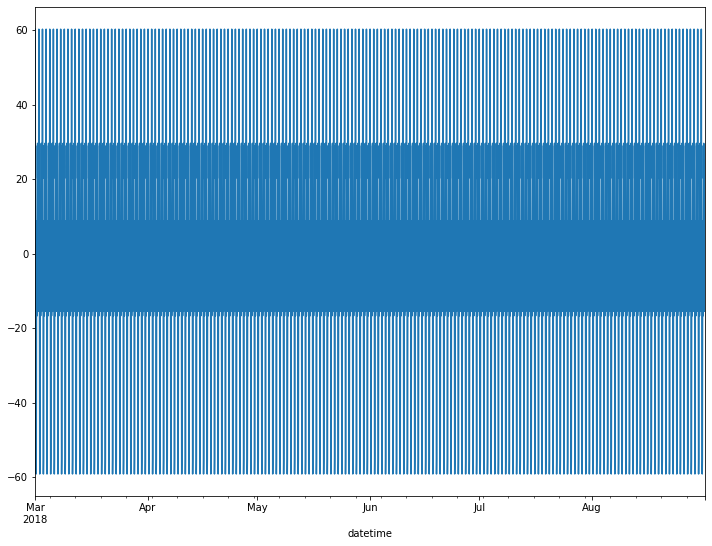

In [18]:
seasonal_decompose(data['num_orders']).seasonal.plot(figsize=(12, 9))

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Сезонность стабильна, но посмотрим на нее чуть внимательнее</div>

<AxesSubplot:xlabel='datetime'>

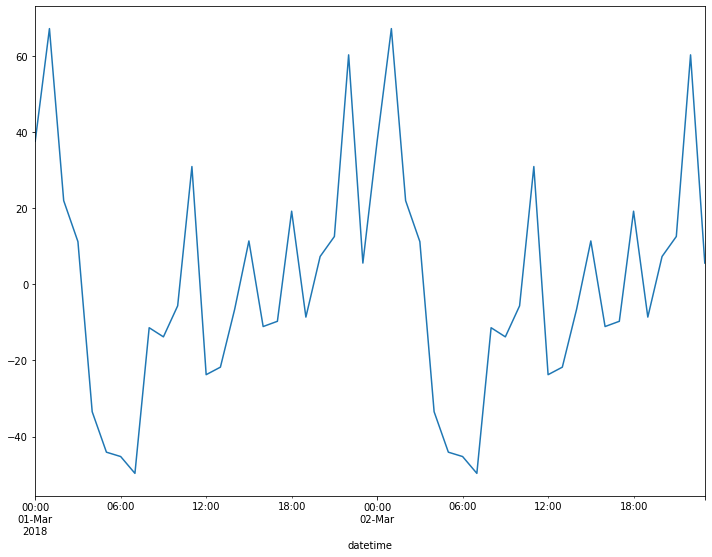

In [19]:
seasonal_decompose(data['num_orders'].iloc[:48]).seasonal.plot(figsize=(12, 9))

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Спад в 6 утра и пик в полночь, похоже на аэропорт</div>

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Посмотрим на разности</div>

In [20]:
data['time_shift'] = data['num_orders'] - data['num_orders'].shift(24)

<AxesSubplot:xlabel='datetime'>

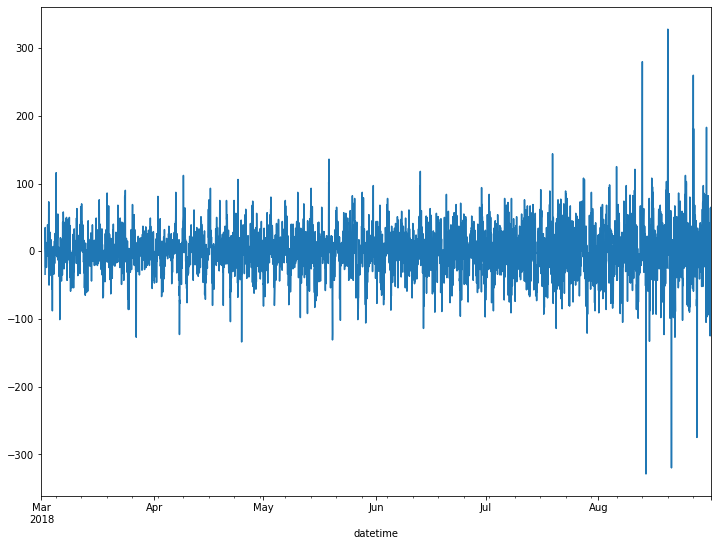

In [21]:
data['time_shift'].plot(figsize=(12, 9))

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Уверенная стационарность, за исключением стандартного отклонения – под конец оно выше, да и в процессе, бывает, встречается</div>

### 2.2.2.   Выделение признаков

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Очистим данные, полученные при анализе</div>

In [22]:
data = data[['num_orders']]

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Создадим функцию, выделяющую основные признаки</div>

In [23]:
def create_features(data, lags=3, roll=3):    
    data.loc[:, 'day'] = data.index.day
    data.loc[:, 'dayofweek'] = data.index.dayofweek
    data.loc[:, 'hour'] = data.index.hour
    
    for lag in range(1, lags+1):
        data[f'lag_{lag}'] = data['num_orders'].shift(lag)
    
    data[f'rolling_{roll}'] = data['num_orders'].shift().rolling(roll).mean()
    
    return data

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Отлично, теперь можно переходить к обучению</div>

## 2.3.   Обучение

### 2.3.1.   Универсальная функция

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
При разделении train : valid : test будем использовать соотношение 75 : 15 : 10</div>

In [24]:
def make_split(data, lag, roll):
    # разделяю данные на выборки
    new_data = create_features(data, lag, roll)
    train, valitest = train_test_split(new_data, shuffle=False, train_size=0.75)
    train = train.dropna()
    valid, test = train_test_split(valitest, shuffle=False, test_size=0.4)

    # делю выборки на features и target
    features_train = train.drop('num_orders', axis=1)
    target_train = train['num_orders']
    features_valid = valid.drop('num_orders', axis=1)
    target_valid = valid['num_orders']
    return features_train, target_train, features_valid, target_valid

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Функция, в которой обучаем модель, предсказываем и отдаем RMSE</div>

In [25]:
def make_pred(Algo, features_train, target_train, features_valid, target_valid):
    model = Algo
    model.fit(features_train, target_train)

    # предсказываю и считаю RMSE
    predicted = model.predict(features_valid)
    model_rmse = mean_squared_error(predicted, target_valid)**0.5
    return model_rmse

### 2.3.2.   LinearRegression

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Начнем с классики – линейная регрессия. Будем перебирать значения лагов и роллинга от 1 до 10, выберем то что даст лучший результат по RMSE</div>

In [26]:
%%time

best_rmse = None
best_lag = None
best_roll = None

for lag in range(1, 11):
    for roll in [3, 6, 12, 24, 48]:
        
        features_train, target_train, features_valid, target_valid = make_split(data.copy(), 
                                                                                lag, 
                                                                                roll)
        model = LinearRegression()
        model_rmse = make_pred(model, features_train, target_train, 
                               features_valid, target_valid)

        if not best_rmse:
            best_rmse = model_rmse
        if model_rmse < best_rmse:
            best_rmse = model_rmse
            best_lag = lag
            best_roll = roll

print((best_rmse, best_lag, best_roll), end='\n\n')

(39.18269053575869, 9, 48)

CPU times: user 2.18 s, sys: 1.31 s, total: 3.49 s
Wall time: 3.5 s


<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
3 секунды, RMSE на уровне 39, лучший лаг 9, лучший ролл 48</div>

### 2.3.3.   DecisionTreeRegressor

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Здесь будем перебирать еще так же max_depth</div>

In [27]:
%%time

best_rmse = None
best_lag = None
best_roll = None
best_depth = None

for lag in range(1, 11):
    for roll in [3, 6, 12, 24, 48]:
        for max_depth in range(4, 17, 2):

            features_train, target_train, features_valid, target_valid = make_split(data.copy(), 
                                                                                    lag, 
                                                                                    roll)
            model = DecisionTreeRegressor(random_state=12345, max_depth=max_depth)
            model_rmse = make_pred(model, features_train, target_train, 
                                          features_valid, target_valid)

            if not best_rmse:
                best_rmse = model_rmse
            if model_rmse < best_rmse:
                best_rmse = model_rmse
                best_lag = lag
                best_roll = roll
                best_depth = max_depth

print((best_rmse, best_lag, best_roll, best_depth), end='\n\n')

(34.1007839781787, 3, 48, 10)

CPU times: user 12.1 s, sys: 54.5 ms, total: 12.1 s
Wall time: 12.2 s


<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Довольно точный – показатель RMSE 34</div>

### 2.3.4.   RandomForestRegressor

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Данный показатель ограничим в глубине обучения, так как при высоких настройках это будет супердолго. Однако, добавляются еще n_estimators</div>

In [28]:
%%time

best_rmse = None
best_lag = None
best_roll = None
best_depth = None
best_n_estimators = None

for lag in range(4, 7):
    for roll in [24, 36, 48, 60]:
        for max_depth in range(20, 25, 2):
            for n_estimators in range(95, 106, 5):

                features_train, target_train, features_valid, target_valid = make_split(data.copy(), 
                                                                                        lag, 
                                                                                        roll)
                model = RandomForestRegressor(random_state=12345, 
                                              max_depth=max_depth, 
                                              n_estimators=n_estimators)
                model_rmse = make_pred(model, features_train, target_train, 
                                              features_valid, target_valid)

                if not best_rmse:
                    best_rmse = model_rmse
                if model_rmse < best_rmse:
                    best_rmse = model_rmse
                    best_lag = lag
                    best_roll = roll
                    best_depth = max_depth
                    best_n_estimators = n_estimators

print((best_rmse, best_lag, best_roll, best_depth, best_n_estimators), end='\n\n')

(29.85219692218834, 5, 60, 24, 105)

CPU times: user 3min 1s, sys: 580 ms, total: 3min 1s
Wall time: 3min 3s


<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Еще точнее, долгий, но RMSE 30</div>

### 2.3.5.   CatBoostRegressor

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Этот алгоритм мы так же ограничим, чтобы не тратить так много времени</div>

In [29]:
%%time

best_rmse = None
best_lag = None
best_roll = None
best_n_estimators = None

for lag in range(1, 5):
    for roll in [3, 6, 12, 24, 48]:
        for n_estimators in range(115, 126, 5):

            features_train, target_train, features_valid, target_valid = make_split(data.copy(), 
                                                                                    lag, 
                                                                                    roll)
            model = CatBoostRegressor(random_state=12345, 
                                      n_estimators=n_estimators, 
                                      verbose=0)
            model_rmse = make_pred(model, features_train, target_train, 
                                          features_valid, target_valid)

            if not best_rmse:
                best_rmse = model_rmse
            if model_rmse < best_rmse:
                best_rmse = model_rmse
                best_lag = lag
                best_roll = roll
                best_n_estimators = n_estimators

print((best_rmse, best_lag, best_roll, best_n_estimators), end='\n\n')

(31.17168166258607, 2, 24, 120)

CPU times: user 13.8 s, sys: 1 s, total: 14.8 s
Wall time: 1min 19s


<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Чуть меньшая точность, но более быстрое время работы</div>

### 2.3.6.   Вывод

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Берем CatBoostRegressor (ограничения по времени не было, но чуть более низкая точность не перекрывает скорости) с настройками лаги = 2, роллинг = 24, n_estimators = 120</div>

## 2.4.   Тестирование

In [30]:
new_data = create_features(data.copy(), 5, 60)
train, test = train_test_split(new_data, shuffle=False, train_size=0.9)
train = train.dropna()

# делю выборки на features и target
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

In [31]:
test_model = RandomForestRegressor(random_state=12345, max_depth=24, n_estimators=105)

test_model.fit(features_train, target_train)

predicted = test_model.predict(features_test)

In [34]:
test_rmse = mean_squared_error(predicted, target_test)**0.5

print(test_rmse)

## 2.5.   Вывод

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Были проверены 4 модели машинного обучения:
<br><br>- Линейная регрессия
<br><br>- Дерево решений
<br><br>- Рандомный лес деревьев
<br><br>- Регрессор CatBoost</div>

<div style="background-color: #fff0e0; padding: 10px; font-family: monospace; font-size: 15px">
Лучше всех себя показал CatBoostRegressor с доп. настройками. На тестовых данных значение RMSE составило 9.5</div>